In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [70]:
#pip install --upgrade scikit-learn

In [71]:
import shap

shap.initjs()

# Data

In [72]:
df = pd.read_csv('selected_feature_dataset')

In [73]:
df.head()

,TARGET,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,ID
0,1.0,0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,...,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,NaN,NaN,NaN,100002
1,0.0,1,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,...,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,NaN,NaN,NaN,100003
2,0.0,0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,...,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,NaN,NaN,NaN,100004
3,0.0,1,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,...,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,NaN,0.0,0.0,100006
4,0.0,0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,...,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,NaN,NaN,NaN,100007


In [74]:
labels = df['TARGET']
ID = df['ID']

pred_data = df.drop(['TARGET', 'ID'], axis = 1)

In [75]:
features = list(pred_data.columns)
features

['CODE_GENDER',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'LIVINGAREA_MEDI',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'NAME_CONTRACT_TYPE_Cashloans',
 'NAME_INCOME_TYPE_Stateservant',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Highereducation',
 'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
 'NAME_FAMILY_STATUS_Married',
 'OCCUPATION_TYPE_Drivers',
 'ORGANIZATION_TYPE_Selfemployed',
 'DAYS_EMPLOYED_PERC',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'BURO_AMT_CREDIT_SUM_SUM',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',


In [76]:
df['NAME_FAMILY_STATUS_Married']

0         0
1         1
2         0
3         0
4         0
         ..
356226    0
356227    1
356228    1
356229    1
356230    1
Name: NAME_FAMILY_STATUS_Married, Length: 356231, dtype: int64

In [77]:
df['DAYS_LAST_PHONE_CHANGE']

0        -1134.0
1         -828.0
2         -815.0
3         -617.0
4        -1106.0
           ...  
356226    -684.0
356227       0.0
356228    -838.0
356229   -2308.0
356230    -327.0
Name: DAYS_LAST_PHONE_CHANGE, Length: 356231, dtype: float64

In [78]:
Gender = df['CODE_GENDER']
Gender = list(df['CODE_GENDER'].replace({0:'Female',1:'Male'}).unique())
    
Gender

['Female', 'Male']

In [79]:
df['DAYS_EMPLOYED'].isna().sum()

64645

In [80]:
df['NAME_FAMILY_STATUS_Married'].value_counts()

1    228697
0    127534
Name: NAME_FAMILY_STATUS_Married, dtype: int64

In [81]:
df['PAYMENT_RATE']

0         0.060749
1         0.027598
2         0.050000
3         0.094941
4         0.042623
            ...   
356226    0.042354
356227    0.051267
356228    0.105414
356229    0.055840
356230    0.079003
Name: PAYMENT_RATE, Length: 356231, dtype: float64

# Model

In [82]:
# load model:
loaded_model = pickle.load(open("model_final.pickle.dat", "rb"))

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Feature: 0, Score: 0.01571
Feature: 1, Score: 0.00595
Feature: 2, Score: 0.00822
Feature: 3, Score: 0.00858
Feature: 4, Score: 0.00284
Feature: 5, Score: 0.00534
Feature: 6, Score: 0.03102
Feature: 7, Score: 0.00215
Feature: 8, Score: 0.00451
Feature: 9, Score: 0.01119
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00737
Feature: 12, Score: 0.02206
Feature: 13, Score: 0.07322
Feature: 14, Score: 0.06918
Feature: 15, Score: 0.00758
Feature: 16, Score: 0.00222
Feature: 17, Score: 0.00721
Feature: 18, Score: 0.00368
Feature: 19, Score: 0.00808
Feature: 20, Score: 0.02305
Feature: 21, Score: 0.00489
Feature: 22, Score: 0.02676
Feature: 23, Score: 0.07988
Feature: 24, Score: 0.01131
Feature: 25, Score: 0.00641
Feature: 26, Score: 0.00226
Feature: 27, Score: 0.00358
Feature: 28, Score: 0.00329
Feature: 29, Score: 0.00429
Feature: 30, Score: 0.01083
Feature: 31, Score: 0.00527
Feature: 32, Score: 0.01123
Feature: 33, Score: 0.00252
Feature: 34, Score: 0.00210
Feature: 35, Score: 0.00584
Fe

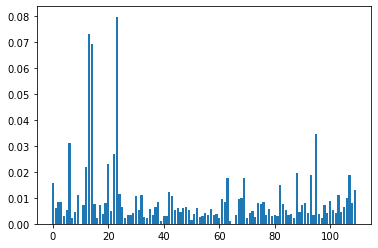

In [83]:
# feature importance
importance = loaded_model.feature_importances_

for i,v in enumerate(importance):
  print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))],importance)
plt.show()

# Feature importance avec SHAP

## Global:

In [84]:
gbt_explainer = shap.TreeExplainer(loaded_model, data = pred_data)

100%|===================| 356135/356231 [12:43<00:00]        

Base Value :  -0.5092476056724581


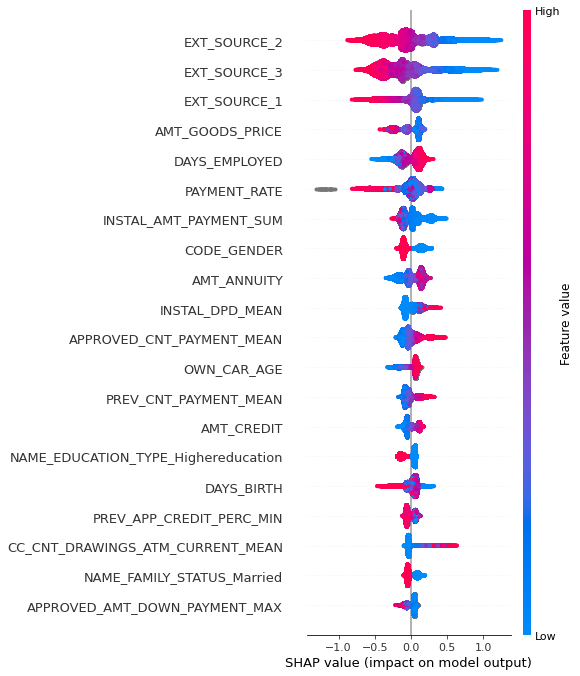

In [85]:
shap_vals = gbt_explainer.shap_values(pred_data)

# save model:
pickle.dump(gbt_explainer, open("model_explainer", "wb"))
pickle.dump(shap_vals, open("shap_values", "wb"))
pickle.dump(gbt_explainer.expected_value, open("expected_values", "wb"))

print("Base Value : ", gbt_explainer.expected_value)

## Shap summary plot
shap.summary_plot(shap_vals, pred_data)

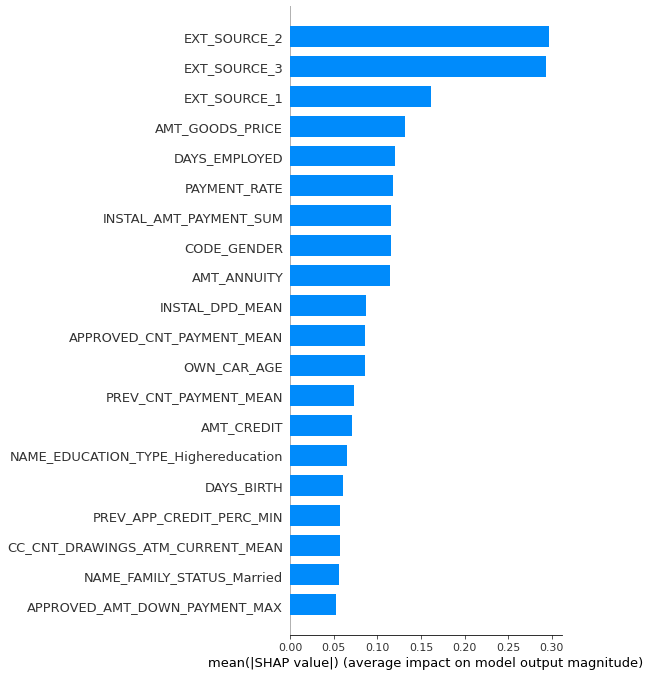

In [86]:
shap.summary_plot(shap_vals, pred_data, plot_type="bar")

100%|===================| 106558/106869 [03:46<00:00]        

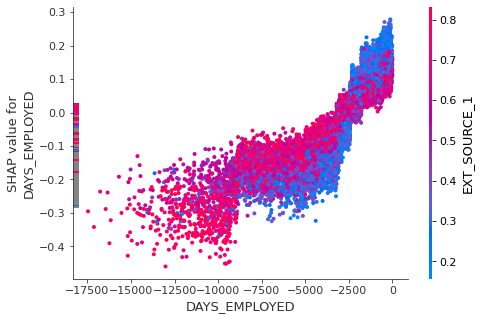

In [87]:
sample_data = pred_data.sample(frac=0.30)

shap_values_sample = gbt_explainer.shap_values(sample_data)

shap.dependence_plot( 'DAYS_EMPLOYED', shap_values_sample, sample_data)

## Local:

In [88]:
## exemple pour un individu :

row = 5
data_a_predire = pred_data.iloc[row] 
data_prediction_array = data_a_predire.values.reshape(1, -1)

loaded_model.predict_proba(data_prediction_array)

shap_values_indiv = gbt_explainer.shap_values(data_a_predire)

shap.force_plot(gbt_explainer.expected_value, shap_values_indiv, data_a_predire)

Base Value :  -0.5092476056724581

Shap Values for Sample 10 :  [[ 0.07724794 -0.03860415 -0.00844588 ... -0.03333745  0.00405727
  -0.00438119]
 [-0.09076263  0.13242715  0.12533597 ... -0.02189275  0.00221742
  -0.00452141]
 [ 0.19730629 -0.08575199 -0.21506154 ... -0.03963353  0.01064637
  -0.00820836]
 ...
 [ 0.11968986  0.13450324  0.16348317 ... -0.03494945  0.0039828
  -0.00476441]
 [-0.11482946  0.12967718  0.14385463 ... -0.01523203 -0.06595305
  -0.01180059]
 [ 0.18098426 -0.05256531 -0.01163803 ... -0.03230583  0.0100497
  -0.00664672]]




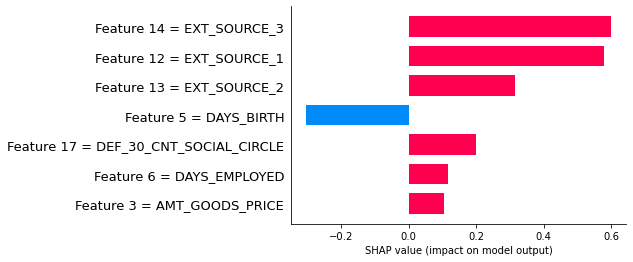

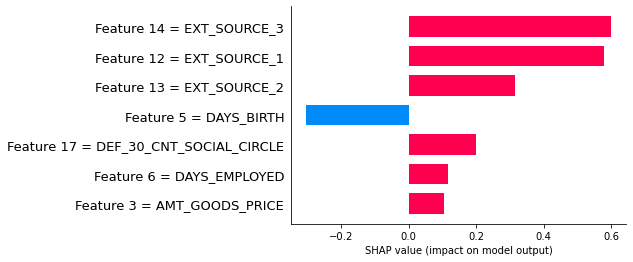

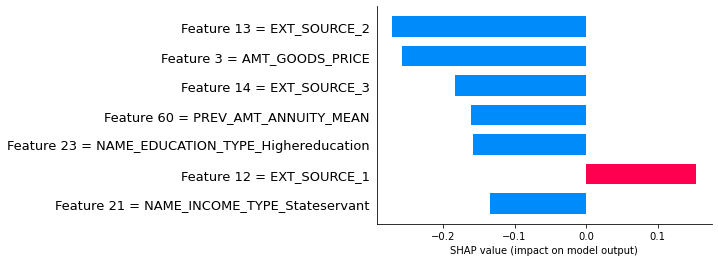

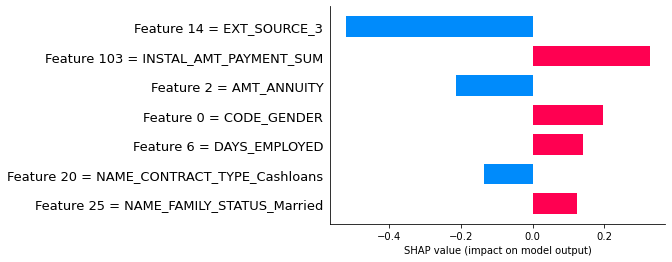

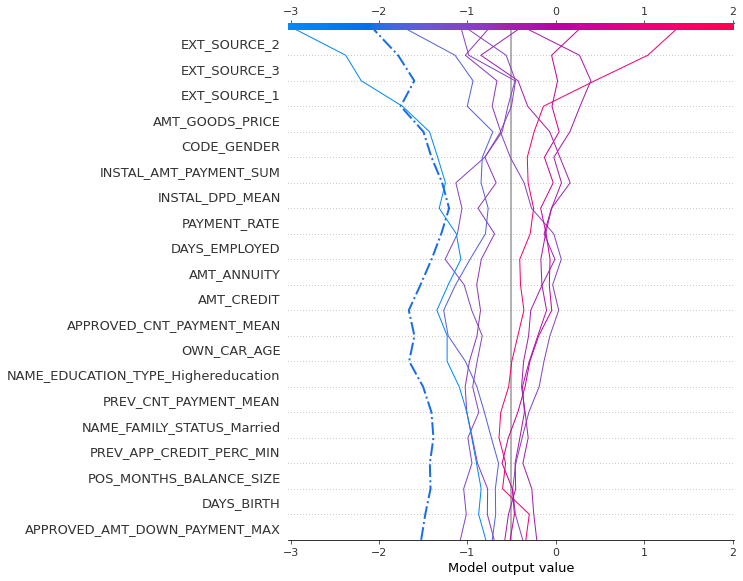

In [89]:
## sur un sous ensemble des données: (11 premiers clients du valid set)

X_test = pred_data

sample_idx = 10

shap_vals = gbt_explainer.shap_values(X_test[:sample_idx])

val1 = gbt_explainer.expected_value + shap_vals.sum()


print("Base Value : ", gbt_explainer.expected_value)
print()
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("\n")

## Barplot

shap.bar_plot(shap_vals[0], X_test[:sample_idx])

shap_vals

shap.bar_plot(shap_vals[0], pred_data)

shap.bar_plot(shap_vals[1], pred_data)

shap.bar_plot(shap_vals[2], pred_data)

## Decision plot first 11 clients

shap.decision_plot(gbt_explainer.expected_value.tolist(),
                               gbt_explainer.shap_values(X_test[:sample_idx]),
                               features=X_test,
                               highlight = [1]
                               )

## Force plot sur subsample:

shap.force_plot(gbt_explainer.expected_value ,shap_vals[0], X_test[:sample_idx].iloc[0])

for i in range(10):
    display(shap.force_plot(gbt_explainer.expected_value ,shap_vals[i], X_test[:sample_idx].iloc[i]))

# Construction des explications de features:

In [90]:
features

['CODE_GENDER',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'LIVINGAREA_MEDI',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'NAME_CONTRACT_TYPE_Cashloans',
 'NAME_INCOME_TYPE_Stateservant',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Highereducation',
 'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
 'NAME_FAMILY_STATUS_Married',
 'OCCUPATION_TYPE_Drivers',
 'ORGANIZATION_TYPE_Selfemployed',
 'DAYS_EMPLOYED_PERC',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'BURO_AMT_CREDIT_SUM_SUM',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',


In [91]:
with open('HomeCredit_columns_description.csv') as f:
    print(f)

<_io.TextIOWrapper name='HomeCredit_columns_description.csv' mode='r' encoding='cp1252'>


In [92]:
description = pd.read_csv('HomeCredit_columns_description.csv', encoding = "cp1252")

In [93]:
description.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [94]:
description = pd.read_csv('description_features.csv', encoding = "cp1252")

In [95]:
description = description.drop(["Unnamed: 0"], axis = 1)
description

,Feature,description
0,CODE_GENDER,Gender of the client
1,AMT_CREDIT,Credit amount of the loan
2,AMT_ANNUITY,Loan annuity
3,AMT_GOODS_PRICE,For consumer loans it is the price of the good...
4,REGION_POPULATION_RELATIVE,Normalized population of region where client l...
...,...,...
105,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,When was the installments of previous credit p...
106,INSTAL_DAYS_ENTRY_PAYMENT_SUM,When was the installments of previous credit p...
107,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,Amount drawing at ATM during the month of the ...
108,CC_CNT_DRAWINGS_CURRENT_MEAN,Mean Amount drawing during the month of the pr...


In [96]:
description.to_csv("desc_features.csv", header = True, index = False)

In [97]:
description.head()

,Feature,description
0,CODE_GENDER,Gender of the client
1,AMT_CREDIT,Credit amount of the loan
2,AMT_ANNUITY,Loan annuity
3,AMT_GOODS_PRICE,For consumer loans it is the price of the good...
4,REGION_POPULATION_RELATIVE,Normalized population of region where client l...


In [98]:
description = pd.read_csv('desc_features.csv')

In [99]:
description

,Feature,description
0,CODE_GENDER,Gender of the client
1,AMT_CREDIT,Credit amount of the loan
2,AMT_ANNUITY,Loan annuity
3,AMT_GOODS_PRICE,For consumer loans it is the price of the good...
4,REGION_POPULATION_RELATIVE,Normalized population of region where client l...
...,...,...
105,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,When was the installments of previous credit p...
106,INSTAL_DAYS_ENTRY_PAYMENT_SUM,When was the installments of previous credit p...
107,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,Amount drawing at ATM during the month of the ...
108,CC_CNT_DRAWINGS_CURRENT_MEAN,Mean Amount drawing during the month of the pr...
